In [1]:
import os, sys, time, re, collections, operator, copy, itertools, zipfile, jellyfish
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option("display.max_columns", 99) # permet de voir toutes les colonnes
sns.set(style="white", color_codes=True)

FOLDER = "/media/shared_ardalan_evgeny/"

def loadFileinZipFile(zip_filename, dtypes=None, parsedate=None, password=None, **kvargs):
    """
    Load file to dataframe.
    """
    with zipfile.ZipFile(zip_filename, 'r') as myzip:
        if password:
            myzip.setpassword(password)

        inside_zip_filename = myzip.filelist[0].filename

        if parsedate:
            pdtrain = pd.read_csv(myzip.open(inside_zip_filename), sep=',', parse_dates=parsedate, dtype=dtypes,
                                  **kvargs)
        else:
            pdtrain = pd.read_csv(myzip.open(inside_zip_filename), sep=',', dtype=dtypes, **kvargs)
        return pdtrain, inside_zip_filename

In [2]:
pdtrain_part1 = pd.read_hdf(FOLDER + "train_merged-part1.h")
pdtrain_part2 = pd.read_hdf(FOLDER + "train_merged-part2.h")
pdtrain = pdtrain_part1.append(pdtrain_part2)
pdtest = pd.read_hdf(FOLDER + "test_merged.h")

del pdtrain_part1
del pdtrain_part2

Opening /media/shared_ardalan_evgeny/train_merged-part1.h in read-only mode
Opening /media/shared_ardalan_evgeny/train_merged-part2.h in read-only mode
Opening /media/shared_ardalan_evgeny/test_merged.h in read-only mode


In [3]:
pdtrain.title_1.fillna("", inplace=True)
pdtrain.title_2.fillna("", inplace=True)

pdtrain.description_1.fillna("", inplace=True)
pdtrain.description_2.fillna("", inplace=True)

pdtrain.attrsJSON_1.fillna("", inplace=True)
pdtrain.attrsJSON_2.fillna("", inplace=True)

pdtest.title_1.fillna("", inplace=True)
pdtest.title_2.fillna("", inplace=True)

pdtest.description_1.fillna("", inplace=True)
pdtest.description_2.fillna("", inplace=True)

pdtest.attrsJSON_1.fillna("", inplace=True)
pdtest.attrsJSON_2.fillna("", inplace=True)

pdtrain.price_1.fillna(99999999, inplace=True)
pdtrain.price_2.fillna(99999999, inplace=True)

pdtest.price_1.fillna(99999999, inplace=True)
pdtest.price_2.fillna(99999999, inplace=True)

pdtrain['images_array_1'].fillna("", inplace=True)
pdtrain['images_array_2'].fillna("", inplace=True)

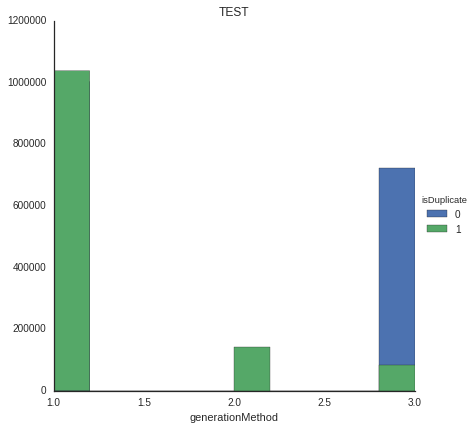

In [4]:
sns.FacetGrid(pdtrain, hue="isDuplicate", size=6) \
   .map(plt.hist, "generationMethod") \
   .add_legend()
plt.title('TEST')
plt.show()

In [20]:
pdtrain_features = pd.DataFrame()
pdtrain_features['isDuplicate'] = pdtrain['isDuplicate']

In [21]:
from math import radians
def haversine(pddata, lon1='', lat1='', lon2='', lat2=''):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1 = pddata[lon1].apply(radians).values
    lat1 = pddata[lat1].apply(radians).values
    lon2 = pddata[lon2].apply(radians).values
    lat2 = pddata[lat2].apply(radians).values

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

# titles
pdtrain_features['title_diff_len'] = np.abs(pdtrain['title_2'].apply(len) - pdtrain['title_1'].apply(len))
# pdtrain_features['title_dlevenshtein'] = pd.read_hdf(FOLDER + "feat_train_title_demarauleven.h")
# pdtrain_features['title_jarowinkler'] = pd.read_hdf(FOLDER + "feat_train_title_jarowinkler.h")
# pdtrain_features['title_num_same'] = pd.read_hdf(FOLDER + "feat_train_title_num_same.h")
# pdtrain_features['title_1_len'] = pdtrain['title_1'].str.len()
# pdtrain_features['title_2_len'] = pdtrain['title_2'].str.len()

# description
pdtrain_features['description_diff_len'] = np.abs(pdtrain['description_2'].apply(len) - pdtrain['description_1'].apply(len))
# pdtrain_features['description_dlevenshtein'] = pd.read_hdf(FOLDER + "feat_train_description_demarauleven.h")
# pdtrain_features['description_jarowinkler'] = pd.read_hdf(FOLDER + "feat_train_description_jarowinkler.h")
# pdtrain_features['description_1_len'] = pdtrain['description_1'].str.len()
# pdtrain_features['description_2_len'] = pdtrain['description_2'].str.len()


# price
pdtrain_features['price_same'] = 1 * (pdtrain['price_1'] == pdtrain['price_2'])
pdtrain_features['price_diff'] = np.abs(pdtrain['price_1']-pdtrain['price_2'])*1./(np.abs(pdtrain['price_1']) + np.abs(pdtrain['price_2']))
pdtrain_features['price_diff'].fillna(-9999, inplace=True)


# attrJson
pdtrain_features['attrsJSON_diff_len'] = np.abs(pdtrain['attrsJSON_1'].apply(len) - pdtrain['attrsJSON_2'].apply(len))
# pdtrain_features['attrsJSON_dlevenshtein'] = pd.read_hdf(FOLDER + "feat_train_attrsJSON_demarauleven.h")
# pdtrain_features['attrsJSON_jarowinkler'] = pd.read_hdf(FOLDER + "feat_train_attrsJSON_jarowinkler.h")
# pdtrain_features['attrsJSON_1_len'] = pdtrain['attrsJSON_1'].str.len()
# pdtrain_features['attrsJSON_2_len'] = pdtrain['attrsJSON_2'].str.len()


# images_array
pdtrain_features['images_diff_number'] = np.abs(pdtrain['images_array_1'].apply(lambda x: len(x.split(',')))-pdtrain['images_array_2'].apply(lambda x: len(x.split(','))))

# geographic features
pdtrain_features['metroID_same'] = 1 * (pdtrain['metroID_1'] == pdtrain['metroID_2'])
pdtrain_features['locationID_same'] = 1 * (pdtrain['locationID_1'] == pdtrain['locationID_2'])
pdtrain_features['regionID_same'] = 1 * (pdtrain['regionID_1'] == pdtrain['regionID_2'])
pdtrain_features['haversine'] = haversine(pdtrain, lon1='lon_1', lat1='lat_1', lon2='lon_2', lat2='lat_2')
pdtrain_features['haversine'] = (pdtrain_features['haversine'] - pdtrain_features['haversine'].mean()) / pdtrain_features['haversine'].std()

['isDuplicate', 'title_diff_len', 'description_diff_len', 'price_same', 'price_diff', 'attrsJSON_diff_len', 'images_diff_number', 'metroID_same', 'locationID_same', 'regionID_same', 'haversine']


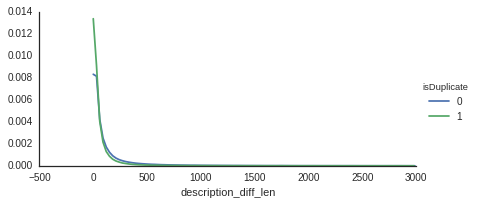

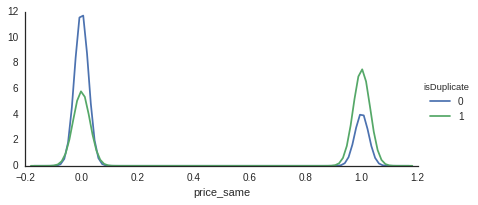

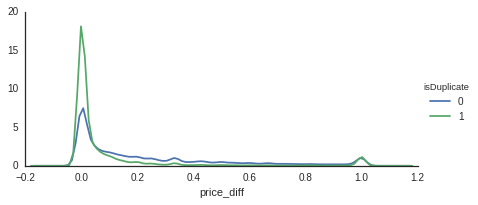

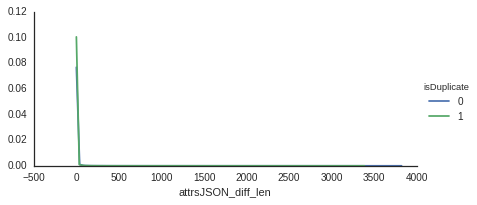

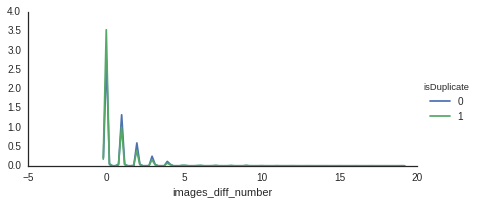

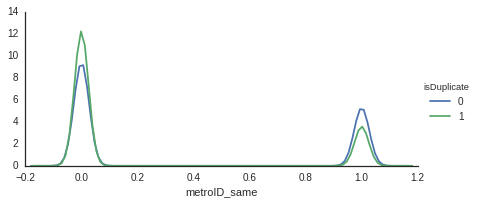

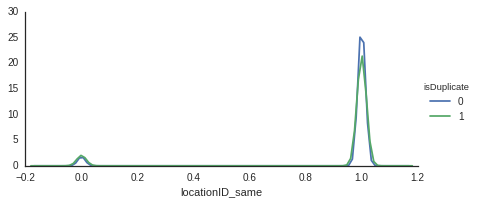

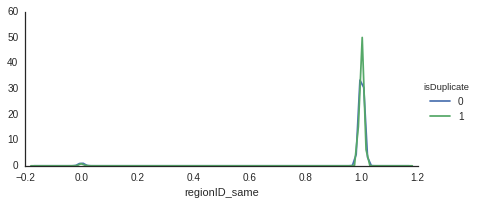

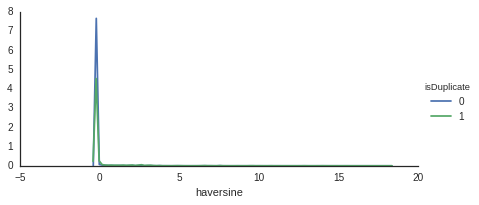

In [25]:
features = list(pdtrain_features.columns.values)
print(features)
for f in features[2:]:
    facet = sns.FacetGrid(pdtrain_features, hue="isDuplicate",aspect=2)
    facet.map(sns.kdeplot,f,shade= False)
    facet.add_legend()

In [8]:
pdtrain_features['categoryID'] = pdtrain['categoryID_1']


In [9]:
pdtrain_features['generationMethod'] = pdtrain['generationMethod']


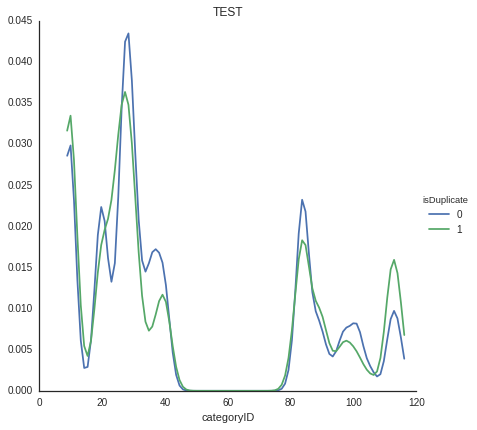

In [64]:
sns.FacetGrid(pdtrain_features, hue="isDuplicate", size=6) \
   .map(sns.kdeplot, "categoryID") \
   .add_legend()
plt.title('TEST')
plt.show()

In [69]:
duplicates_per_cat1 = pdtrain.groupby(['categoryID_1']).agg({'isDuplicate': lambda x: np.sum(x)}).to_dict()
cat1_dic_count = pdtrain.categoryID_1.value_counts().to_dict()

for key in duplicates_per_cat1['isDuplicate']:
    duplicates_per_cat1['isDuplicate'][key] /= cat1_dic_count[key]

In [89]:
pdtrain_features.columns

Index(['isDuplicate', 'title_diff_len', 'description_diff_len', 'price_same',
       'price_diff', 'attrsJSON_diff_len', 'images_diff_number',
       'metroID_same', 'locationID_same', 'regionID_same', 'haversine',
       'categoryID_same', 'categoryID', 'generationMethod'],
      dtype='object')

In [84]:
cor_mat = pdtrain_features.corr()

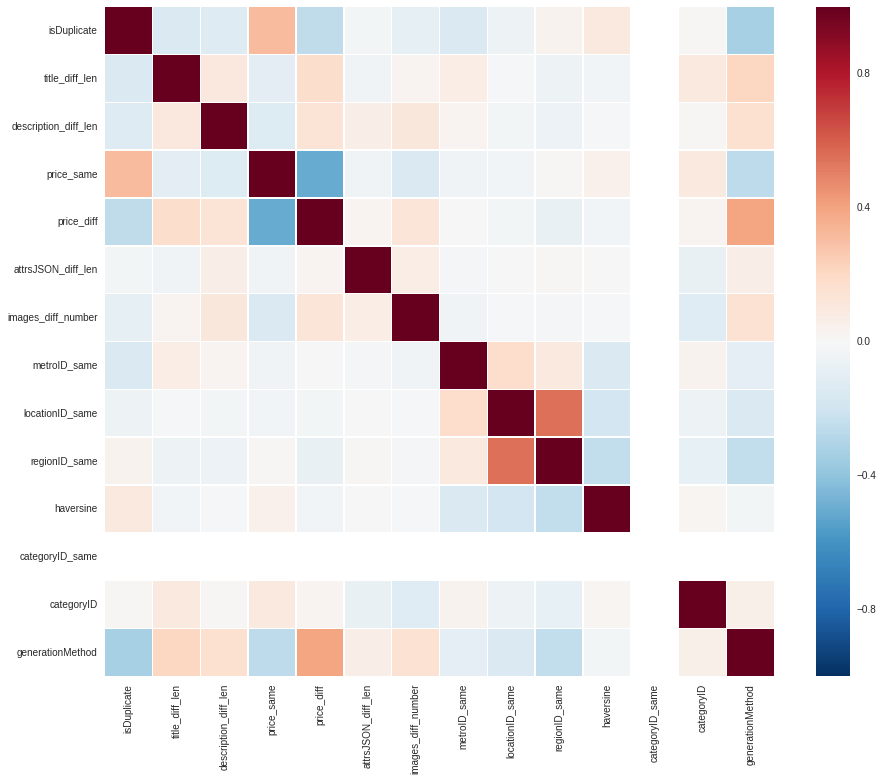

In [85]:
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(cor_mat,linewidths=.5, ax=ax);

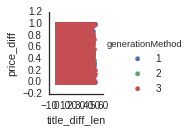

In [15]:
sns.FacetGrid(pdtrain_features, hue="generationMethod", size=2) \
   .map(plt.scatter, "title_diff_len", "price_diff") \
   .add_legend();

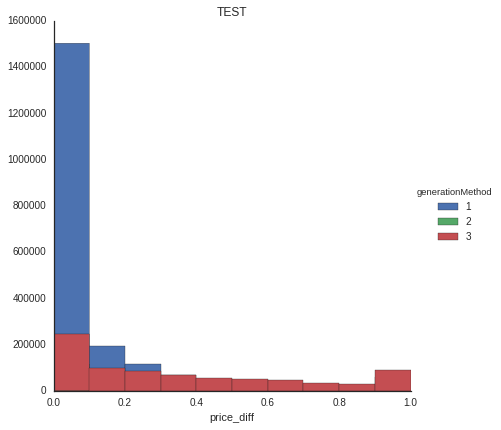

In [10]:
sns.FacetGrid(pdtrain_features, hue="generationMethod", size=6) \
   .map(plt.hist, "price_diff") \
   .add_legend()
plt.title('TEST')
plt.show()

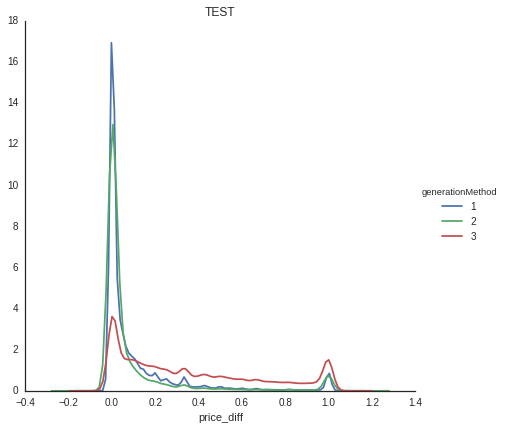

In [11]:
sns.FacetGrid(pdtrain_features, hue="generationMethod", size=6) \
   .map(sns.kdeplot, "price_diff") \
   .add_legend()
plt.title('TEST')
plt.show()

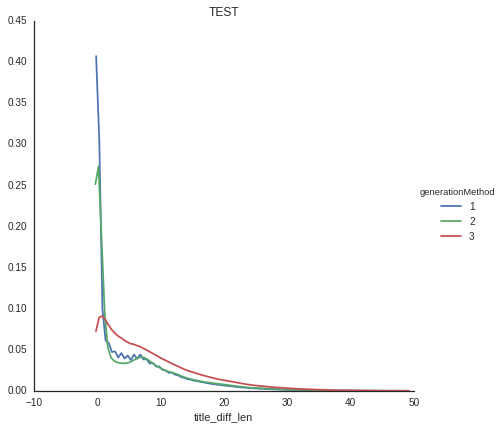

In [12]:
sns.FacetGrid(pdtrain_features, hue="generationMethod", size=6) \
   .map(sns.kdeplot, "title_diff_len") \
   .add_legend()
plt.title('TEST')
plt.show()